In this task, you should train Inception V3 with pytorch using transfer learning to classify CIFAR10 dataset.

In [ ]:
from typing import Tuple, Iterable, List
from tqdm import tqdm
from time import time
import re

import torchvision
from torchvision import datasets, transforms, models
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
SEED = 51
torch.random.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Load the dataset

Load the CIFAR10 dataset bellow. You can use either `torchvision.datasets.CIFAR10` or `sklearn.datasets.fetch_openml()` or any other way to load the dataset.

In [ ]:
cifar_root = 'cifir10'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(cifar_root, train=True, download=True, transform=transform)
trainsize = int(len(trainset) * 0.9)
valsize = len(trainset) - trainsize
trainset, valset = torch.utils.data.random_split(trainset, [trainsize, valsize])
testset = torchvision.datasets.CIFAR10(cifar_root, train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifir10/cifar-10-python.tar.gz to cifir10
Files already downloaded and verified


# Get Inception V3

Instantiate Inception V3 model (pretrained on imagenet) from `torchvision`'s model zoo.

In [ ]:
net = models.inception_v3(pretrained=True).to(device)
net

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Modify for CIFAR10

Imagenet has 1000 classes, but CIFAR10 has 10. So, the decider layers of the model must be changed so that we can use the model for CIFAR10. Therefore, adapt `net.fc` and `net.AuxLogits.fc` with CIFAR10.

In [ ]:
net.fc = nn.Linear(2048, 10).to(device)
net.AuxLogits.fc = nn.Linear(768, 10).to(device)

# Freeze the convolutional part

In order to apply transfer learning, freeze all layers except the deciders. Freezing consist of disabling optimization by disabling grad calculation. Also in batch normalization layers, updating mooving average and variance must be disabled. Note that you must later filter out the frozen parameter for optimizer.

In [ ]:
class TrainDisable:

    def __init__(self, train) -> None:
        self.old_train = train

    def __call__(self, *args, **kwargs) -> None:
        pass

In [ ]:
def freeze(m: nn.Module, pattern: str) -> None:
    regex = re.compile(pattern)

    frozen_names = set()
    for name, p in m.named_parameters():
        if regex.fullmatch(name):
            # print(f'grad off: {name}')
            p.requires_grad = False
            frozen_names.add(name[:name.rfind('.')])

    for name, module in m.named_modules():
        if (name in frozen_names) and isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            # print(f'bn freeze: {name}')
            module.eval()
            module.train = TrainDisable(module.train)

In [ ]:
pattern = r'(?!^.*fc\..*$)(^.*$)'     # Anything except fc

In [ ]:
freeze(net, pattern)

# Instantiate the optimizer

Create the optimizer filtering out freezed parameters.

In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=1e-4)

# Train the model

Write your train/validation loop bellow. Then train the model until it converges. Feel free to add extra cells.

In [ ]:
class Trainer:
    CHECKPOINT = 'cifar-inceptionv3.pth'
    CLASSES = ('plane', 'car', 'bird', 'cat', 
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 trainloader: DataLoader, valloader: DataLoader, testloader: DataLoader,
                 device: torch.device, alpha: float = 0.2) -> None:
        self.__model = model
        self.__optimizer = optimizer
        self.__trainloader = trainloader
        self.__valloader = valloader
        self.__testloader = testloader
        self.__device = device
        self.__train_loss = []
        self.__train_accuracy = []
        self.__val_loss = []
        self.__val_accuracy = []
        self.__best_val_acc = 0
        self.__alpha = alpha

    def __train_epoch(self) -> Tuple[float, float]:
        epoch_loss = 0
        epoch_accuracy = 0
        n = 0

        self.__model.train()
        with tqdm(enumerate(self.__trainloader), total=len(self.__trainloader)) as pbar:
            for i, (x, y) in pbar:
                x = x.to(self.__device)
                y = y.to(self.__device)
                s, s_a = self.__model(x)
                loss = F.cross_entropy(s, y) + self.__alpha * F.cross_entropy(s_a, y)
                true = int((s.argmax(dim=-1) == y).sum())
                epoch_loss += float(loss)
                epoch_accuracy += true
                n += len(x)

                loss.backward()
                self.__optimizer.step()
                self.__optimizer.zero_grad()

                pbar.set_description(f'train loss: {epoch_loss / (i + 1):.3e} - accuracy: {epoch_accuracy * 100.0 / n:.2f}%')

        epoch_loss /= len(self.__trainloader)
        epoch_accuracy *= 100.0 / n
        return epoch_loss, epoch_accuracy

    def __eval_epoch(self, dataloader: DataLoader) -> Tuple[float, float]:
        epoch_loss = 0
        epoch_accuracy = 0
        n = 0

        self.__model.eval()
        with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (x, y) in pbar:
                x = x.to(self.__device)
                y = y.to(self.__device)
                s = self.__model(x)
                loss = F.cross_entropy(s, y)
                true = int((s.argmax(dim=-1) == y).sum())
                epoch_loss += float(loss)
                epoch_accuracy += true
                n += len(x)
                pbar.set_description(f'val loss: {epoch_loss / (i + 1):.3e} - accuracy: {epoch_accuracy * 100.0 / n:.2f}%')

        epoch_loss /= len(dataloader)
        epoch_accuracy *= 100.0 / n
        return epoch_loss, epoch_accuracy

    def __val_epoch(self) -> Tuple[float, float]:
        return self.__eval_epoch(self.__valloader)

    def test(self) -> Tuple[float, float]:
        return self.__eval_epoch(self.__testloader)

    def save(self) -> None:
        torch.save(self.__model.state_dict(), self.CHECKPOINT)

    def load(self) -> None:
        self.__model.load_state_dict(torch.load(self.CHECKPOINT))

    def train(self, max_epochs: int) -> None:
        if len(self.__train_loss) >= max_epochs:
            return

        for e in range(len(self.__train_loss), max_epochs):
            start_time = time()
            train_loss, train_accuracy = self.__train_epoch()
            val_loss, val_accuracy = self.__val_epoch()
            end_time = time()

            if val_accuracy > self.__best_val_acc:
                self.__best_val_acc = val_accuracy
                print(f'Saving checkpoint.')
                self.save()
            
            print(f'Epoch {e+1} finished in {end_time - start_time:.2f}s. Train [loss: {train_loss:.3e}, acc: {train_accuracy:.2f}%] - Val [loss: {val_loss:.3e}, acc: {val_accuracy:.2f}%]')

            self.__train_loss.append(train_loss)
            self.__train_accuracy.append(train_accuracy)
            self.__val_loss.append(val_loss)
            self.__val_accuracy.append(val_accuracy)

    def plot_curves(self) -> None:
        fig = plt.figure(figsize=(15, 7))

        # loss
        ax = fig.add_subplot(121)
        ax.set_title('Loss / Epoch')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.set_aspect('auto')

        plt.plot(self.__train_loss, label='Train', color='green', linewidth=3)
        plt.plot(self.__val_loss, label='Validation', color='red', linewidth=3)

        plt.legend()

        # acc
        ax = fig.add_subplot(122)
        ax.set_title('Accuracy / Epoch')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.set_aspect('auto')

        plt.plot(self.__train_accuracy, label='Train', color='green', linewidth=3)
        plt.plot(self.__val_accuracy, label='Validation', color='red', linewidth=3)

        plt.legend()

    def predict(self) -> Iterable[int]:
        self.__model.eval()
        with torch.no_grad(), tqdm(self.__testloader, total=len(self.__testloader)) as pbar:
            for x, _ in pbar:
                yield from self.__model(x.to(self.__device)).argmax(dim=-1)

    def draw_misclassified(self, n: int) -> None:
        p = list(self.predict())
        missed_idx = np.random.choice([i for i, (x, y) in enumerate(self.__testloader.dataset) if p[i] != y], size=n)
        missed_samples = [self.__testloader.dataset[i] for i in missed_idx]
        wrong_labels = [p[i] for i in missed_idx]
        correct_labels = [s[1] for s in missed_samples]
        images = [s[0].permute((1, 2, 0)) for s in missed_samples]

        texts = [f'{self.CLASSES[correct]} -> {self.CLASSES[missed]}' for missed, correct in zip(wrong_labels, correct_labels)]

        columns = 10
        rows = int(np.ceil(n / columns))
        fig = plt.figure(figsize=(2 * columns, 2 * rows))
        for i in range(columns * rows):
            ax = fig.add_subplot(rows, columns, i + 1)
            ax.set_title(texts[i])
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.imshow((images[i] - images[i].min()) / (images[i].max() - images[i].min()))

        cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.set_frame_on(False)

In [ ]:
B = 128
EB = 256
trainloader = DataLoader(trainset, batch_size=B, shuffle=True)
valloader = DataLoader(valset, batch_size=EB, shuffle=False)
testloader = DataLoader(testset, batch_size=EB, shuffle=False)
trainer = Trainer(net, optimizer, trainloader, valloader, testloader, device)
net

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
trainer.train(20)

val loss: 1.066e+00 - accuracy: 72.26%: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Saving checkpoint.
Epoch 1 finished in 586.60s. Train [loss: 1.843e+00, acc: 55.97%] - Val [loss: 1.066e+00, acc: 72.26%]


val loss: 8.415e-01 - accuracy: 74.62%: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it]


Saving checkpoint.
Epoch 2 finished in 582.11s. Train [loss: 1.179e+00, acc: 70.42%] - Val [loss: 8.415e-01, acc: 74.62%]


val loss: 7.550e-01 - accuracy: 76.36%: 100%|██████████| 20/20 [00:55<00:00,  2.80s/it]


Saving checkpoint.
Epoch 3 finished in 574.90s. Train [loss: 1.011e+00, acc: 72.82%] - Val [loss: 7.550e-01, acc: 76.36%]


val loss: 7.082e-01 - accuracy: 77.12%: 100%|██████████| 20/20 [00:56<00:00,  2.84s/it]


Saving checkpoint.
Epoch 4 finished in 576.12s. Train [loss: 9.366e-01, acc: 73.88%] - Val [loss: 7.082e-01, acc: 77.12%]


val loss: 6.760e-01 - accuracy: 77.90%: 100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


Saving checkpoint.
Epoch 5 finished in 578.92s. Train [loss: 8.917e-01, acc: 74.67%] - Val [loss: 6.760e-01, acc: 77.90%]


val loss: 6.548e-01 - accuracy: 78.50%: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it]


Saving checkpoint.
Epoch 6 finished in 576.85s. Train [loss: 8.597e-01, acc: 75.28%] - Val [loss: 6.548e-01, acc: 78.50%]


val loss: 6.394e-01 - accuracy: 78.86%: 100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


Saving checkpoint.
Epoch 7 finished in 575.85s. Train [loss: 8.373e-01, acc: 75.90%] - Val [loss: 6.394e-01, acc: 78.86%]


val loss: 6.240e-01 - accuracy: 79.46%: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it]


Saving checkpoint.
Epoch 8 finished in 576.64s. Train [loss: 8.224e-01, acc: 76.06%] - Val [loss: 6.240e-01, acc: 79.46%]


val loss: 6.130e-01 - accuracy: 79.88%: 100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


Saving checkpoint.
Epoch 9 finished in 576.47s. Train [loss: 8.067e-01, acc: 76.63%] - Val [loss: 6.130e-01, acc: 79.88%]


val loss: 6.055e-01 - accuracy: 80.12%: 100%|██████████| 20/20 [00:56<00:00,  2.84s/it]


Saving checkpoint.
Epoch 10 finished in 579.50s. Train [loss: 7.965e-01, acc: 76.81%] - Val [loss: 6.055e-01, acc: 80.12%]


val loss: 5.958e-01 - accuracy: 80.42%: 100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


Saving checkpoint.
Epoch 11 finished in 585.42s. Train [loss: 7.833e-01, acc: 76.97%] - Val [loss: 5.958e-01, acc: 80.42%]


val loss: 5.897e-01 - accuracy: 80.70%: 100%|██████████| 20/20 [00:57<00:00,  2.85s/it]


Saving checkpoint.
Epoch 12 finished in 586.11s. Train [loss: 7.766e-01, acc: 77.33%] - Val [loss: 5.897e-01, acc: 80.70%]


val loss: 5.831e-01 - accuracy: 80.74%: 100%|██████████| 20/20 [00:56<00:00,  2.85s/it]


Saving checkpoint.
Epoch 13 finished in 583.04s. Train [loss: 7.657e-01, acc: 77.65%] - Val [loss: 5.831e-01, acc: 80.74%]


val loss: 5.793e-01 - accuracy: 80.82%: 100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


Saving checkpoint.
Epoch 14 finished in 584.31s. Train [loss: 7.614e-01, acc: 77.72%] - Val [loss: 5.793e-01, acc: 80.82%]


val loss: 5.745e-01 - accuracy: 81.04%: 100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


Saving checkpoint.
Epoch 15 finished in 585.99s. Train [loss: 7.565e-01, acc: 77.70%] - Val [loss: 5.745e-01, acc: 81.04%]


val loss: 5.715e-01 - accuracy: 80.98%: 100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


Epoch 16 finished in 587.21s. Train [loss: 7.495e-01, acc: 77.88%] - Val [loss: 5.715e-01, acc: 80.98%]


val loss: 5.669e-01 - accuracy: 81.12%: 100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


Saving checkpoint.
Epoch 17 finished in 587.00s. Train [loss: 7.434e-01, acc: 78.15%] - Val [loss: 5.669e-01, acc: 81.12%]


val loss: 5.614e-01 - accuracy: 81.48%: 100%|██████████| 20/20 [00:57<00:00,  2.85s/it]


Saving checkpoint.
Epoch 18 finished in 586.70s. Train [loss: 7.413e-01, acc: 78.30%] - Val [loss: 5.614e-01, acc: 81.48%]


val loss: 5.593e-01 - accuracy: 81.36%: 100%|██████████| 20/20 [00:56<00:00,  2.84s/it]


Epoch 19 finished in 585.87s. Train [loss: 7.378e-01, acc: 78.26%] - Val [loss: 5.593e-01, acc: 81.36%]


val loss: 5.564e-01 - accuracy: 81.54%: 100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


Saving checkpoint.
Epoch 20 finished in 580.14s. Train [loss: 7.366e-01, acc: 78.17%] - Val [loss: 5.564e-01, acc: 81.54%]


# Draw the training curves

Draw two diagrams for train and validat
ion, one showing loss of each epoch, and another showing accuracy of each epoch.

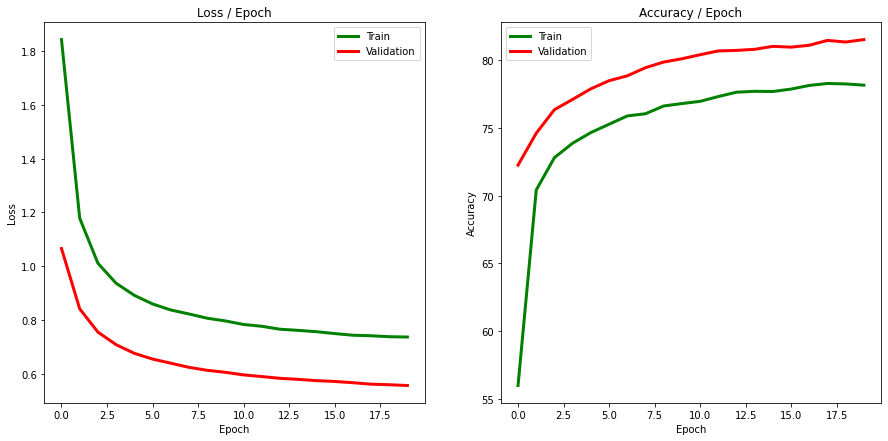

In [ ]:
trainer.plot_curves()
plt.show()

# Evaluate your model

Evaluate the best epoch's model (according to the validation accuracy) on the test set, and report the accuracy. Is your model overfitted?

In [ ]:
trainer.load()
_, accuracy = trainer.test()
accuracy

val loss: 5.987e-01 - accuracy: 79.82%: 100%|██████████| 40/40 [01:53<00:00,  2.83s/it]


79.82000000000001

# Draw misclassified images

Draw 20 misclassified images from test set with expected and predicted labels.

100%|██████████| 40/40 [01:18<00:00,  1.96s/it]


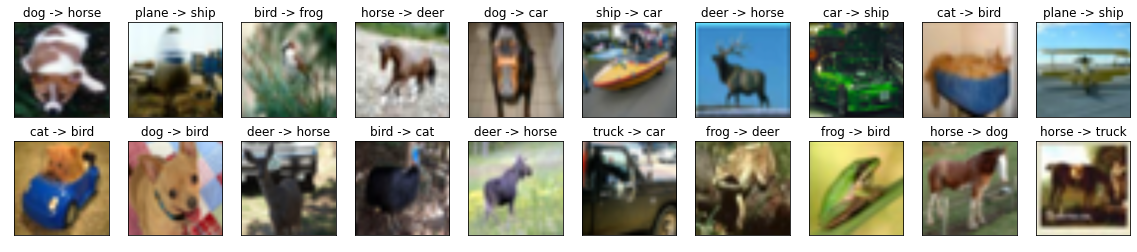

In [ ]:
trainer.draw_misclassified(20)